#### Set experiment parameters in config
For training that terminates in a reasonable timeframe use data in sample_subset/audio.
This is not a real dataset as it consists of 10 images, but the functionality of the code can be examined.
The full dataset can be found here "https://magenta.withgoogle.com/datasets/nsynth#files" It must first be extracted, for example with the function in data_work.ipynb. To use the full dataset, preprocessing is recommend. A function for this purpose can also be found in the data_work notebook. To continue with the experiment, set the parameters of the config to something reasonable for your hardware like done bewlow:

In [1]:
from config import load_config
config = load_config()
#Set folder to sample dataset for prototyping
#config.data.train_audio_folder = 'data/sample_subset/audio'
#config.data.test_audio_folder = 'data/sample_subset/audio'
config.vae.batch_size = 256

In [ ]:
from train_vae import train, test
from datasets import HDF5SpectrogramDataset, collate_fn, SpectogramDataset
from VAE_models import VAE, count_parameters

from datetime import datetime
import os

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch


train_data = HDF5SpectrogramDataset('data/train_spectrograms.h5')
test_data = HDF5SpectrogramDataset('data/valid_spectrograms.h5')
#train_data = SpectogramDataset(config.data.train_audio_folder)
#test_data = SpectogramDataset(config.data.val_audio_folder)
train_loader = DataLoader(train_data, batch_size=config.vae.batch_size, shuffle=True, pin_memory=True, num_workers=8, persistent_workers=True, prefetch_factor=2)
test_loader = DataLoader(test_data, batch_size=config.vae.batch_size, shuffle=False, pin_memory=True, num_workers=2, persistent_workers=True)

sample_spec = train_data[0] # Sample spectogram 
in_dim = sample_spec.numel() # For spectograms = width * height

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join(config.log_dir, timestamp)
os.makedirs(log_dir, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = VAE(in_dim, config.vae.latent_dim, config.vae.n_layers, config.vae.beta_kl).to(device)
print(count_parameters(model))

torch.set_float32_matmul_precision("medium")
#model = torch.compile(model, mode="max-autotune")

optimizer = torch.optim.Adam(model.parameters(), lr=config.vae.lr, weight_decay=config.vae.weight_decay)
writer = SummaryWriter(log_dir)
prev_updates = 0
for epoch in range(config.vae.epochs):
    print(f'Epoch {epoch+1}/{config.vae.epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, config, device=device, writer=writer)
    test(model, test_loader, prev_updates, config, device, writer=writer)


cuda
4273920
Epoch 1/50


  0%|          | 5/1130 [00:01<03:54,  4.81it/s]

Step 0 (N samples: 0), Loss: 15830.6260 (Recon: 15822.6016, KL: 8.0243) Grad: nan


 45%|████▌     | 509/1130 [00:13<00:15, 39.17it/s]

Step 500 (N samples: 128,000), Loss: 7382.4761 (Recon: 6643.9800, KL: 738.4960) Grad: 1.0000


 89%|████████▉ | 1009/1130 [00:28<00:03, 36.91it/s]

Step 1,000 (N samples: 256,000), Loss: 6713.7686 (Recon: 6127.5898, KL: 586.1790) Grad: 1.0000


Testing: 100%|██████████| 50/50 [00:03<00:00, 13.33it/s]


====> Test set loss: 7095.6901 (BCE: 6412.8056, KLD: 682.8845)
Epoch 2/50


 33%|███▎      | 377/1130 [00:07<00:14, 52.96it/s]

Step 1,500 (N samples: 384,000), Loss: 6574.1030 (Recon: 5936.7793, KL: 637.3239) Grad: 1.0000


 78%|███████▊  | 879/1130 [00:18<00:05, 48.56it/s]

Step 2,000 (N samples: 512,000), Loss: 7010.8291 (Recon: 6324.0547, KL: 686.7743) Grad: 1.0000


 99%|█████████▉| 1122/1130 [00:25<00:00, 44.20it/s]


KeyboardInterrupt: 

In [7]:
if not os.path.isdir('./models'):
    os.mkdir('./models')
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")    
torch.save(model.state_dict(), './models/vae'+timestamp+'.pt')
checkpoint ={
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item() if 'loss' in locals() else None,
            'config': {
                'in_dim': in_dim,
                'latent_dim': config.vae.latent_dim,
                'n_layers': config.vae.n_layers,
                'batch_size': config.vae.batch_size,
                'lr': config.vae.lr
            },
            'timestamp': timestamp            
            }
torch.save(checkpoint, f'./models/vae_checkpoint_{timestamp}.pt')

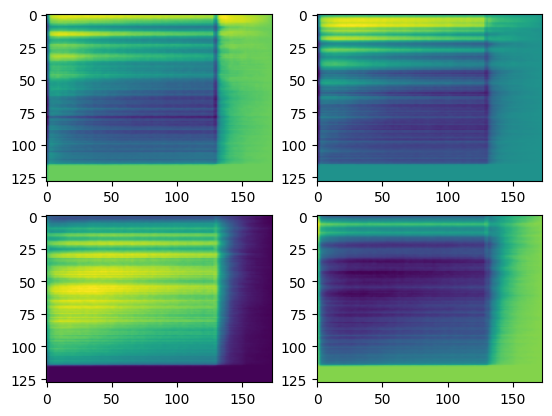

In [9]:
import matplotlib.pyplot as plt
import torch
from VAE_models import load_vae_model

model, checkpoint = load_vae_model('models/vae_checkpoint_20250701-172700.pt', 'cuda')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()

z = torch.randn(4, checkpoint['config']['latent_dim']).to(device)
with torch.no_grad():
    samples = model.decode(z)
samples = samples.cpu().view(4, 128, 173).numpy()
plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(samples[i])

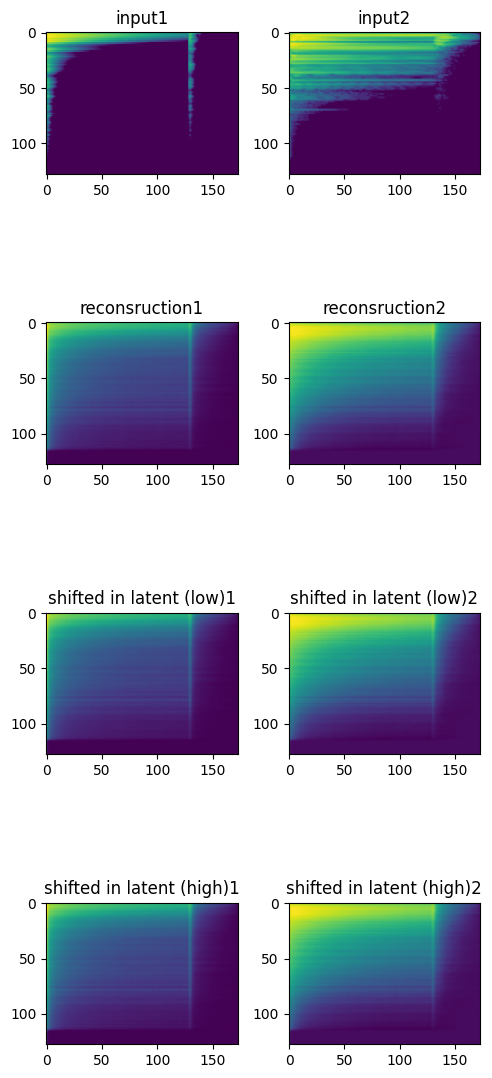

In [32]:
from datasets import HDF5SpectrogramDataset
from torch.utils.data import DataLoader
import numpy as np
num_samples = 2
train_data = HDF5SpectrogramDataset('data/train_spectrograms.h5')
train_loader = DataLoader(train_data, batch_size=num_samples, shuffle=True)

inputs = next(iter(train_loader))

with torch.no_grad():
    inputs = inputs.view(inputs.size(0), -1).to(device)
    dist = model.encode(inputs)
    z_s = model.reparameterize(dist)
    recons = model.decode(z_s).cpu().view(num_samples, 128, 173).numpy()
    shifted_z_s_high = z_s + torch.rand_like(z_s) * 0.1
    shifted_z_s_low = z_s + torch.rand_like(z_s) * 000.1
    shifted_high = model.decode(shifted_z_s_high).cpu().view(num_samples, 128, 173).numpy()
    shifted_low = model.decode(shifted_z_s_low).cpu().view(num_samples, 128, 173).numpy()
    inputs = inputs.cpu().view(num_samples, 128, 173).numpy()
images = np.array([inputs, recons, shifted_high, shifted_low]).reshape((8, 128, 173))
plt.figure(figsize=[5,12])
for i in range(num_samples):
    plt.subplot(4,num_samples,i+1)
    plt.imshow(inputs[i])
    plt.title(f'input{i+1}')
    plt.subplot(4,num_samples,i+num_samples+1)
    plt.imshow(recons[i])
    plt.title(f'reconsruction{i+1}')
    plt.subplot(4,num_samples,i+2*num_samples+1)
    plt.imshow(shifted_low[i])
    plt.title(f'shifted in latent (low){i+1}')
    plt.subplot(4,num_samples,i+3*num_samples+1)
    plt.imshow(shifted_high[i])
    plt.title(f'shifted in latent (high){i+1}')
plt.tight_layout()

